<strong>Classification of Expected User Knowledge From User Metrics

<strong>Introduction:</strong>
In the area of education, there are multiple metrics which can be evaluated in order to rate a student's performance. For example, the relationship between study time, repetition, and exam performance all correlate to a user‘s level of knowledge. In the project, we want to find out which factor or combination of factors can most accurately predicts the true knowledge level of students. One thing we would also want to know is does the test score really reflects your true knowledge level? We believe this is a meaningful and important question, since exams and standardized tests are used everywhere. (Standardized tests such as the ACT and SAT are used to evaluate applicants in many U.S. university.) As there are too many students across multiple school systems, countries, and levels of educational achievement, using certain performance metrics to guess knowledge level becomes important. For this project, we will use "User Knowledge Modeling Data" dataset from UCI to train the model and then perform the analysis. This dataset contains five different quantitative exploratory measures related to learning and study. They are scaled and the value is range from 0 to 1. The details are in the Attribute Information section. It also has a qualitative variable we want to predict, which is the knowledge level of user. The dataset is already being splited into training set and testing set.

<strong>Methods:</strong>

First, we will do a quick inspection into the dataset and conduct a preliminary data analysis to see if we can get some useful information. We will inspect all categories in the part: STG (study time) , SCG (repetition number), STR (study time of user for related objects), LPR (exam performance of user for related objects) and PEG (exam performance) and their relationship to UNS(the knowledge level of user).

After the preliminary analysis, we will use the training set to train our K-NN nearest neighbor model and then evaluate this model using the testing data. We will use the most suitable category or combinations of categories as the predictor variables. The way we choose them is called forward selction and and be throughly explained later. Then, based on the training data, we conduct cross-validation to tune the model and select the most appropriate number of neighbors (k). Finally, using the best model, we evaluate the performance of the model on the testing set.

The visualisation 2D scatter plots that includes crucial predictors determined in the previous step. The x and y will represent the values of these predictors and data points will be coloured by their UNS catgory. We will make two plots. In the first one, the data points from testing set will be coloured by their true UNS catgory. In the second one, they will be coloured by the class we predicted. If we are making fairly accurate predictions, in theory, we should see the consistency of the colour of same data point in these two plots.

<strong>Preliminary exploratory data analysis:

In [27]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(httr)

The dataset is loaded from UCI (UCI Machine Learning Repository: User knowledge modeling data set).
The attribute information is as follows:
STG: The degree of study time for goal object materails.
SCG: The degree of repetition number of user for goal object materails.
STR: The degree of study time of user for related objects with goal object.
LPR: The exam performance of user for related objects with goal object.
PEG: The exam performance of user for goal objects.
UNS: The knowledge level of user.

In [28]:
# load data in and convert <chr> to <fct> for categorical variable UNS
url<-'https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls'
GET(url, write_disk(TF <- tempfile(fileext = ".xls")))

user_training_raw <- read_excel(TF, sheet = "Training_Data")
user_training <- select(user_training_raw, STG:UNS)
user_training[user_training == "very_low"] <- "Very Low"
user_training <- mutate(user_training, UNS = as_factor(UNS))
head(user_training)

user_testing_raw <- read_excel(TF, sheet = "Test_Data")
user_testing <- select(user_testing_raw, STG:UNS)
user_testing <- mutate(user_testing, UNS = as_factor(UNS))
head(user_testing)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls]
  Date: 2022-04-08 21:24
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 57.9 kB
<ON DISK>  /tmp/RtmpEE5HG5/file835bfa06d9.xlsNULL

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High
0.14,0.14,0.70,0.50,0.30,Low


A quick inspection into the data. More specifically, we want to know the overall mean of all the qutitative variables as well as the mean after grouping the observation by their UNS categories.

In [29]:
# mean of all the observations from STG to PEG
overall_mean <- user_training %>% 
                select(STG:PEG) %>% 
                map_dfr(mean)
overall_mean

num_of_observations <- nrow(user_training)
num_of_observations

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.4327132,0.4585388


[1] 258

We have 258 observations in the traning set.

In [30]:
# mean of observations which has "Very Low" UNS from STG to PEG
user_training_very_low <- user_training %>% 
                          filter(UNS == "Very Low")
very_low_mean <- user_training_very_low %>% 
                 select(STG:PEG) %>% 
                 map_dfr(mean)
very_low_mean

num_of_very_low <- nrow(user_training_very_low)
num_of_very_low

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3057917,0.198125,0.36625,0.35875,0.09083333


[1] 24

In [31]:
# mean of observations which has "Low" UNS from STG to PEG
user_training_low <- user_training %>% 
                     filter(UNS == "Low")
low_mean <- user_training_low %>% 
            select(STG:PEG) %>% 
            map_dfr(mean)
low_mean

num_of_low <- nrow(user_training_low)
num_of_low

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3211446,0.337,0.4307229,0.4973494,0.2376265


[1] 83

In [32]:
# mean of observations which has "Middle" UNS from STG to PEG
user_training_middle <- user_training %>% 
                        filter(UNS == "Middle")
middle_mean <- user_training_middle %>% 
               select(STG:PEG) %>% 
               map_dfr(mean)
middle_mean

num_of_middle <- nrow(user_training_middle)
num_of_middle

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3999773,0.3679205,0.5068182,0.3428409,0.5423864


[1] 88

In [33]:
# mean of observations which has "High" UNS from STG to PEG
user_training_high <- user_training %>% 
                      filter(UNS == "High")
high_mean <- user_training_high %>% 
             select(STG:PEG) %>% 
             map_dfr(mean)
high_mean

num_of_high <- nrow(user_training_high)
num_of_high

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.4216508,0.4231905,0.5016667,0.5012698,0.7725397


[1] 63

We noticed that except PEG, we did not find significant diffrence in mean value among these four different UNS levels. For PEG, we found that its mean is higher when the level knowledge increases. However, more analysis needs to be done before making any inference.

Then we plot the distribution of each category based on the five variables (STG, SCG, STR, LPR, and PEG) to tentatively find out which variable can be the most powerful predictor.

In [34]:
# Reordering group factor levels
user_training$UNS <- factor(user_training$UNS, levels = c("Very Low", "Low", "Middle", "High"))
user_testing$UNS <- factor(user_testing$UNS, levels = c("Very Low", "Low", "Middle", "High"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



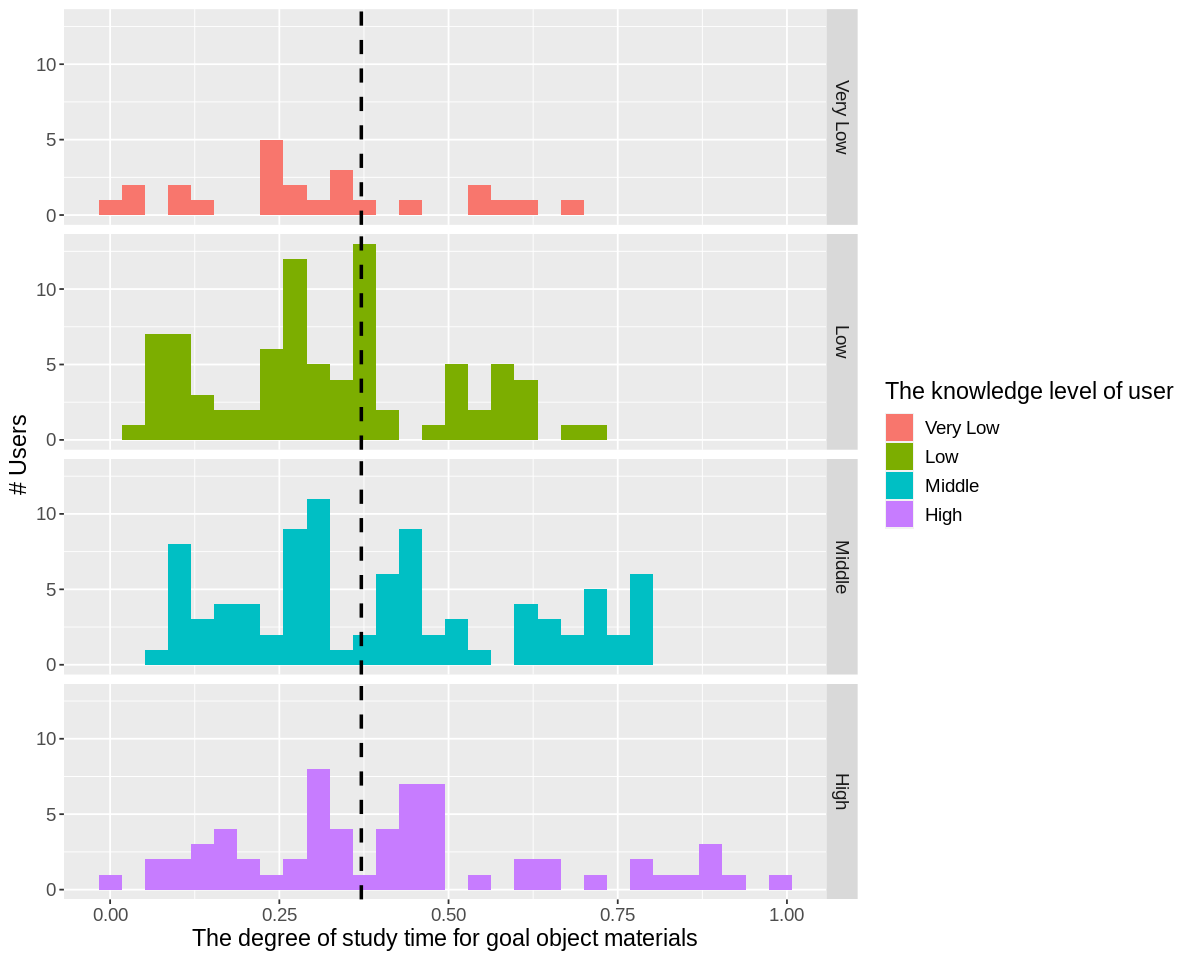

In [62]:
# For users with different knowledge level, plot the distribution of each category's degree of study time 
# for goal object materails (STG), with the overall mean of STG.
options(repr.plot.width = 10, repr.plot.height = 8)
STG_plot <- user_training %>%
    select(STG,UNS) %>%
    ggplot(aes(x = STG, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.3711473, linetype = "dashed", size = 1.0) +
    labs(x = "The degree of study time for goal object materials", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 14))
STG_plot

<span style="color:gray">*Figure 1.1: The degree of study time for goal object materials*</span>.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



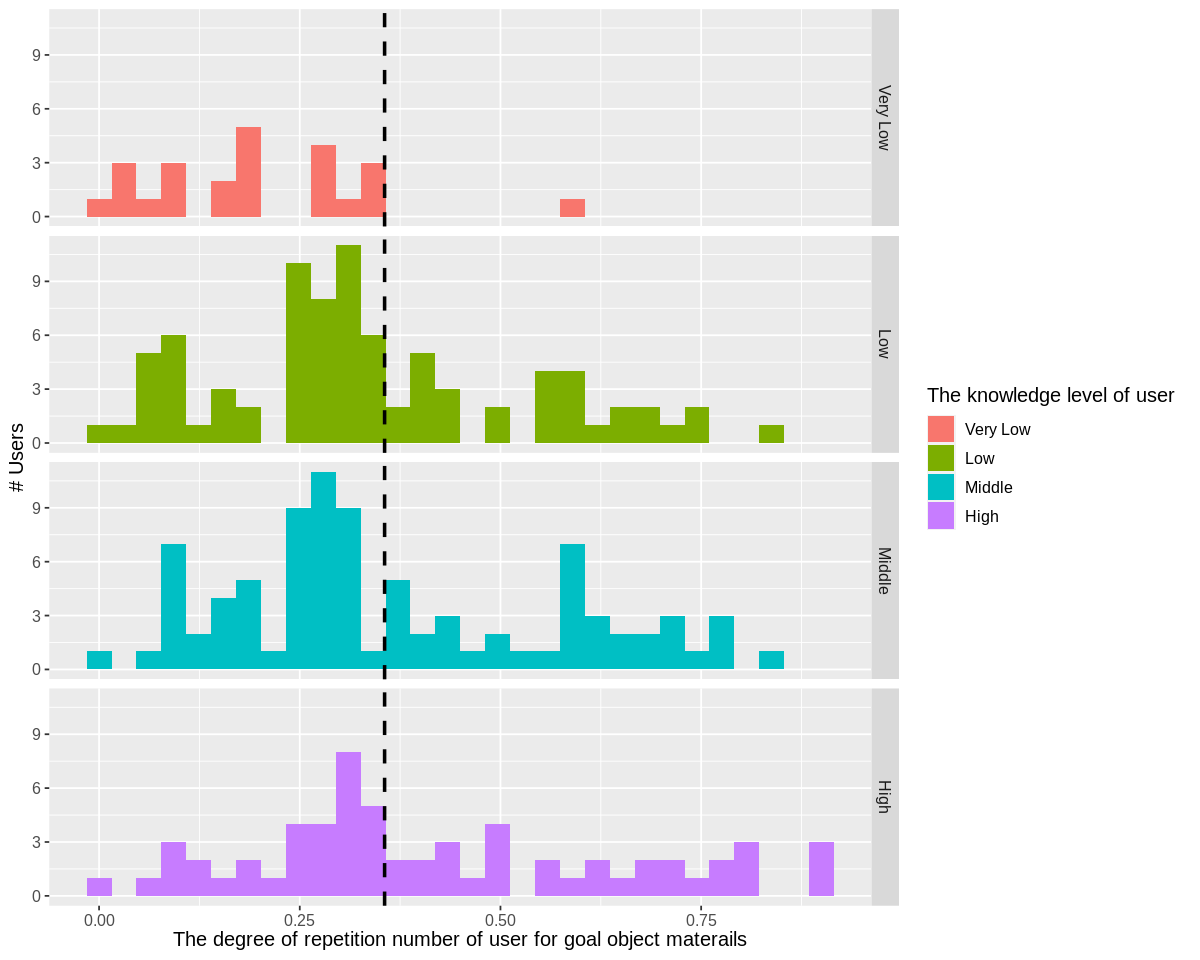

In [36]:
# For users with different knowledge level, plot the distribution of each category's degree of 
# repetition number of user for goal object materails (SCG), with the overall mean of SCG.
SCG_plot <- user_training %>%
    select(SCG,UNS) %>%
    ggplot(aes(x = SCG, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.3556744, linetype = "dashed", size = 1.0) +
    labs(x = "The degree of repetition number of user for goal object materials", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 14))
SCG_plot

<span style="color:gray">*Figure 1.2: The degree of repetition number of user for goal object materials*</span>.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



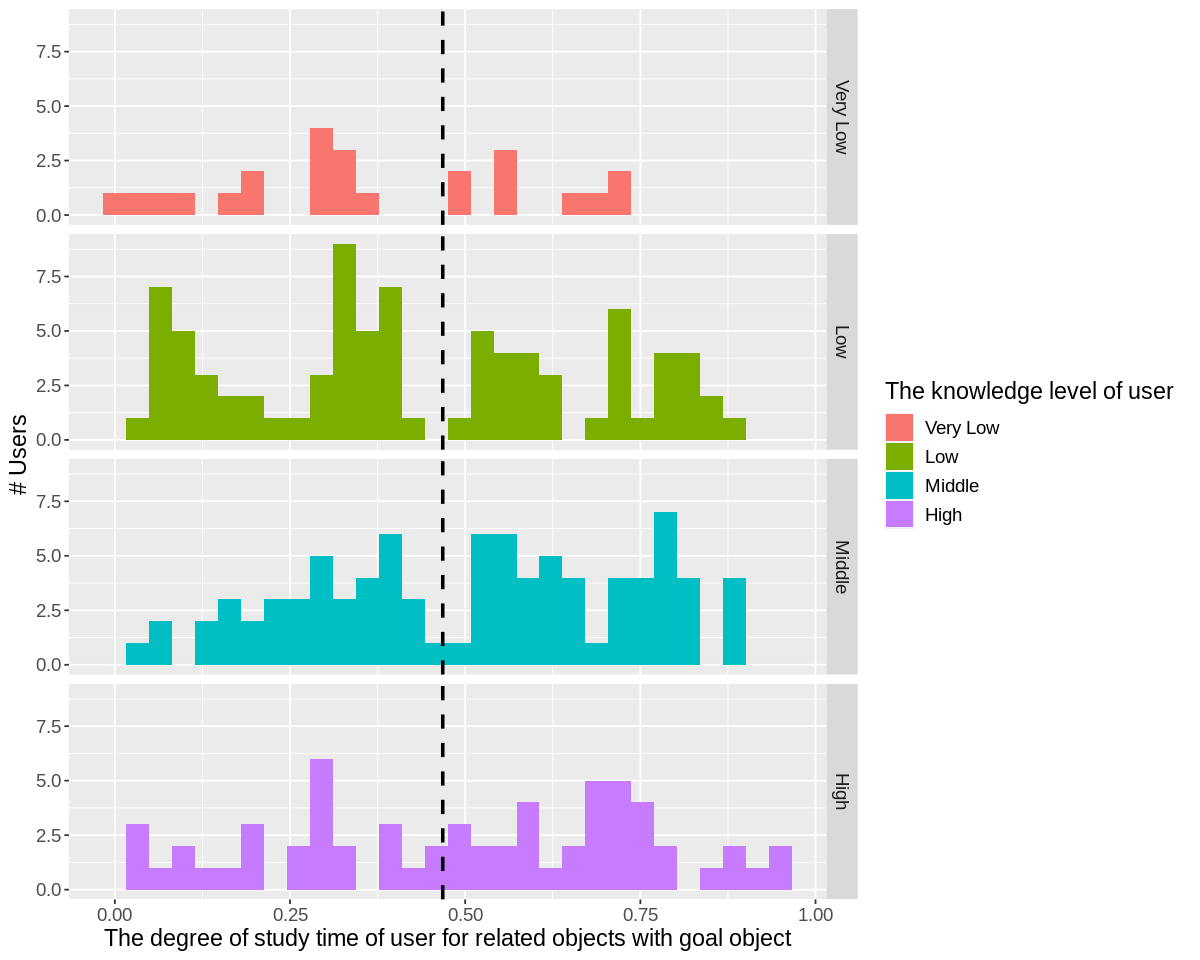

In [63]:
# For users with different knowledge level, plot the distribution of each category's degree of 
# study time of user for related objects with goal object (STR), with the overall mean of STR.
STR_plot <- user_training %>%
    select(STR,UNS) %>%
    ggplot(aes(x = STR, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.4680039, linetype = "dashed", size = 1.0) +
    labs(x = "The degree of study time of user for related objects with goal object", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 14))
STR_plot

<span style="color:gray">*Figure 1.3: The degree of study time of user for related objects with goal object*</span>.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



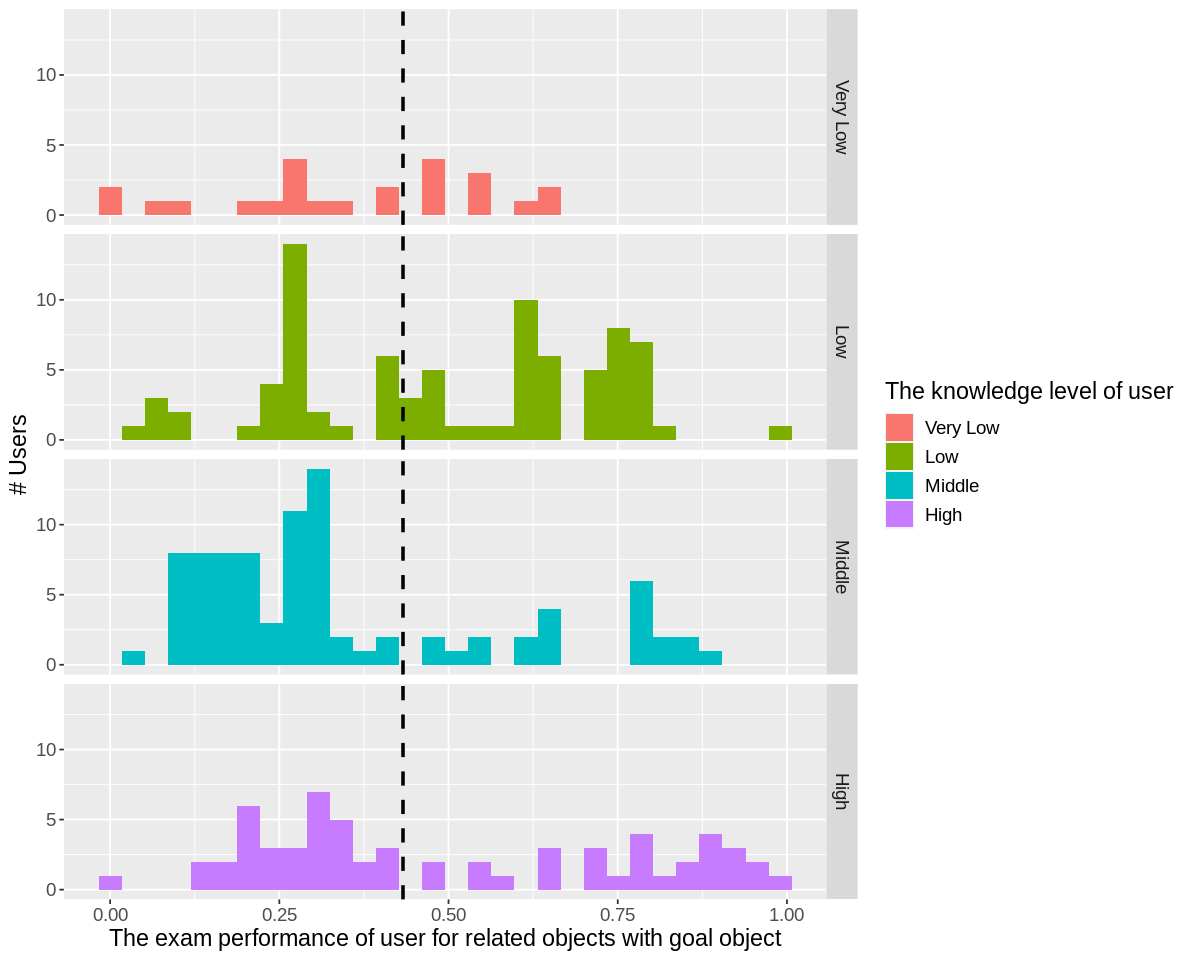

In [64]:
# For users with different knowledge level, plot the distribution of each category's performance
# for related objects with goal object (LPR), with the overall mean of lPR.
LPR_plot <- user_training %>%
    select(LPR,UNS) %>%
    ggplot(aes(x = LPR, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.4327132, linetype = "dashed", size = 1.0) +
    labs(x = "The exam performance of user for related objects with goal object", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 14))
LPR_plot 

<span style="color:gray">*Figure 1.4: The degree of study time of user for related objects with goal object*</span>.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



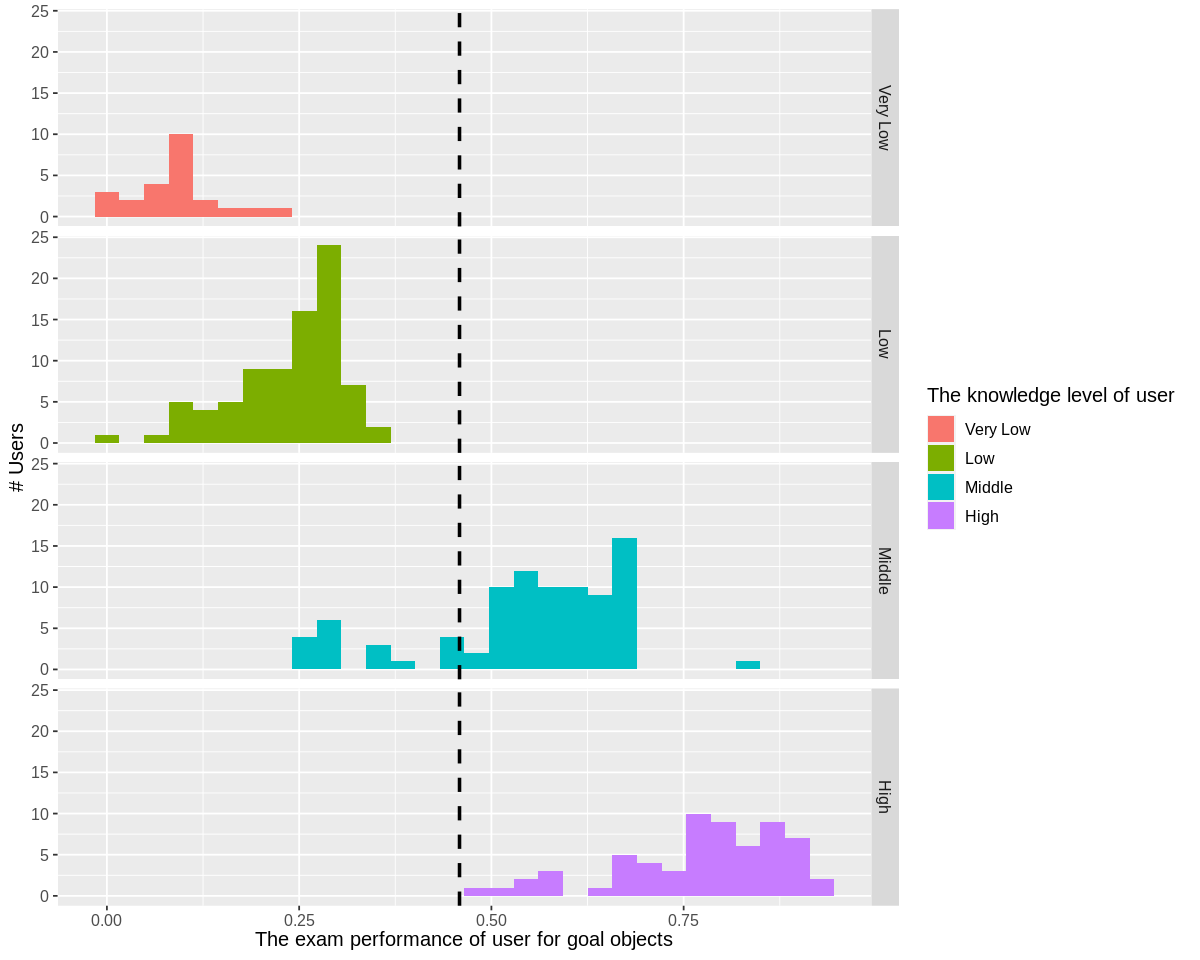

In [65]:
# For users with different knowledge level, plot the distribution of each category's exam performance 
# for goal objects(PEG), with the overall mean of PEG.
PEG_plot <- user_training %>%
    select(PEG,UNS) %>%
    ggplot(aes(x = PEG, fill = UNS)) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.4585388, linetype = "dashed", size = 1.0) +
    labs(x = "The exam performance of user for goal objects", y = "# Users", fill = "The knowledge level of user") +
    theme(text = element_text(size = 12))
PEG_plot

<span style="color:gray">*Figure 1.5: The exam performance of user for goal objects*</span>.

From the plots generated above, it can be observed that, for STG, SCG, STR, and LPR, the distributions of the 4 levels of users do not vary widely. However, the distributions clearly differ when it comes to PEG. This suggests that PEG can be a very important variable for predicting user's knowledge level.

Next, we conduct variable forward selection to choose the best combination of predictor variables. The underlying mechanism is to iteratively build up a model by adding one variable at a time. By doing this, we are able to select the best subset of variables that is most likely to yield an accurate prediction. (Chapter6.8.3, Data Science: A First Introduction)

In [40]:
# Variable Forward Selection

In [41]:
# This is the set of potential variables with the label UNS user_training

In [58]:
# extract the column names for the full set of predictor variables
names <- colnames(user_training %>% select(-UNS))

In [59]:
user_formula <- paste("UNS", "~", paste(names, collapse="+"))
user_formula

[1] "UNS ~ STG+SCG+STR+LPR+PEG"

In [60]:
# set seed to get reproducible result
set.seed(1)
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
cancer_vfold <- vfold_cv(user_training, v = 5, strata = UNS)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        user_recipe <- recipe(as.formula(model_string), 
                                data = user_training) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(user_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = cancer_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies 

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ PEG,0.8413273
2,UNS ~ PEG+LPR,0.9534691
3,UNS ~ PEG+LPR+STG,0.9226244
4,UNS ~ PEG+LPR+STG+SCG,0.8837104
5,UNS ~ PEG+LPR+STG+SCG+STR,0.7715686


According to the result of forward selection of predictor variable, Using PEG and LPR will yield a more accurate prediction of UNS with accuracy of 95.35%. Therefore, we choose PEG and LPR as the predictor variables. This is also accordant with the observation from the exploratory analysis, where we find that PEG is a good predictor. Moreover, adding LPR will give a more accurate result as is shown in the forward selection.

**Modeling**

First, based on PEG and LPR, we create a KNN workflow.

In [49]:
# Construct KNN classification workflow
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("classification") 

knn_recipe <- recipe(UNS ~ PEG + LPR, data = user_training) %>%
       step_scale(all_predictors()) %>%
       step_center(all_predictors())

knn_workflow <- workflow() %>%
        add_recipe(knn_recipe) %>%
        add_model(knn_spec)

Then, we tune the model to find the best k (number of neighbors).

In [54]:
# Tune the model to find the best k (number of neighbours)
user_vfold <- vfold_cv(user_training, v = 5, strata = UNS)

gridvals <- tibble(neighbors = seq(from = 1, to = 20))

knn_fit <- knn_workflow %>%
        tune_grid(resamples = user_vfold, grid = gridvals)

knn_results <- knn_fit %>%
        collect_metrics()

k_best <- knn_results %>%
        filter(.metric == "accuracy") %>%
        arrange(mean) %>% 
        slice(1) %>%
        pull(neighbors)

k_best

[1] 19

Finally, we evaluate the performance of the model on the testing set.

In [55]:
# The model with the best k
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_best) %>%
          set_engine("kknn") %>%
          set_mode("classification")

knn_best_fit <- workflow() %>%
          add_recipe(knn_recipe) %>%
          add_model(knn_best_spec) %>%
          fit(data = user_training)

knn_accuracy <- knn_best_fit %>%
            predict(user_testing) %>%
            bind_cols(user_testing) 

knn_accuracy$.pred_class <- factor(knn_accuracy$.pred_class, levels = c("Very Low", "Low", "Middle","High"))

knn_accuracy %>% metrics(truth = UNS, estimate = .pred_class) %>%
            filter(.metric == "accuracy") %>%
            select(.estimate) %>%
            pull()


[1] 0.9241379

The accuracy given is about 92.4%, which is relatively high. Therefore, it is plausible that the combination of PEG and LPR is a strong predictor for UNS.

Here we will do a visual comparation between the testing data and our prediction to get a more intuitive sence of how accurate our predictions were.
We will make two scatter plots, one for the real categories of UNS in the testing data set and the other one using our predicted categories of UNS.
We chose to put PEG in the x-axis andc LPR is the y-axis as they are the best predictors.

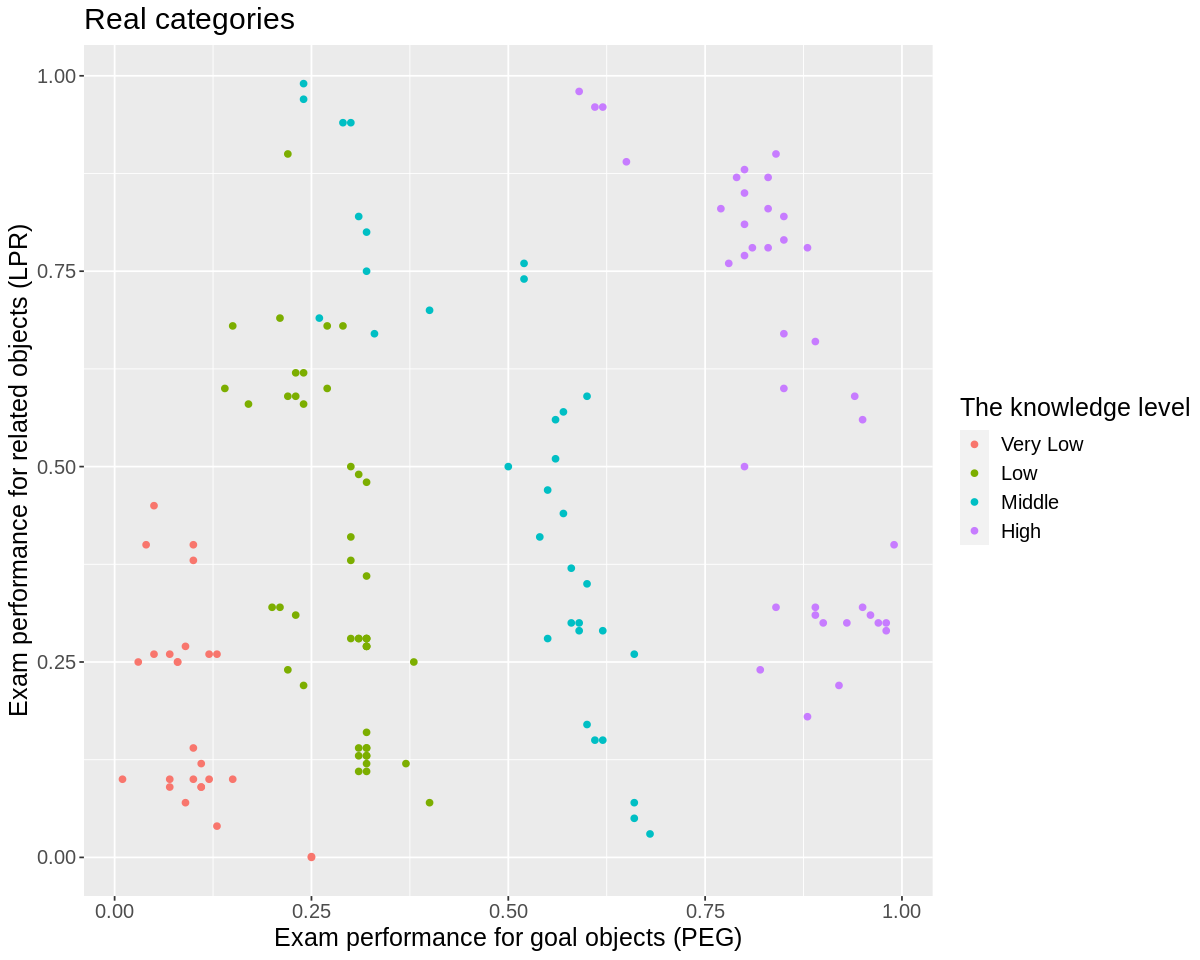

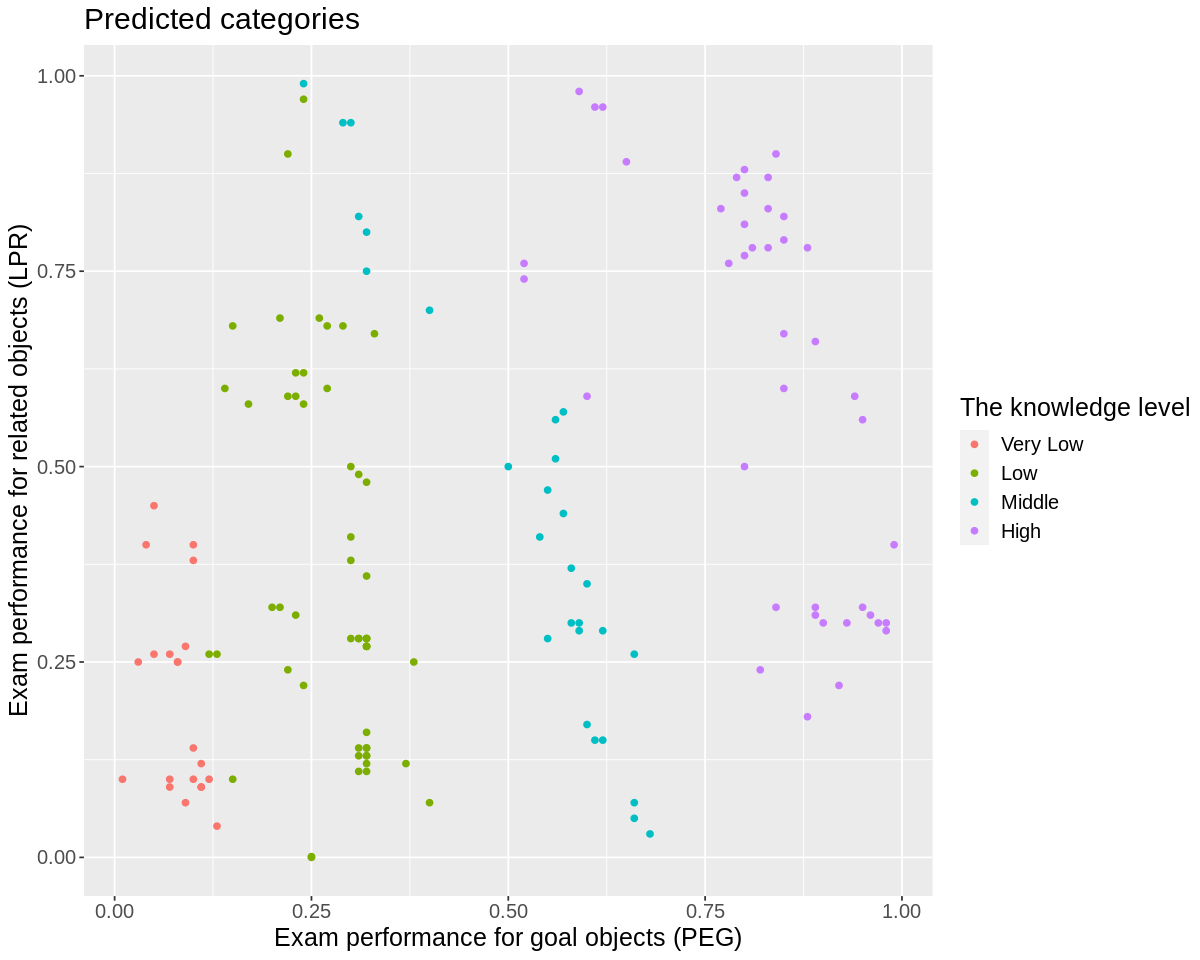

In [48]:
options(repr.plot.width = 10, repr.plot.height = 8)

testing_data_plot <- ggplot(knn_accuracy, aes(x = PEG, y = LPR, colour = UNS)) +
geom_point() +
labs(x = "Exam performance for goal objects (PEG)", y = "Exam performance for related objects (LPR)", color = "The knowledge level") +
ggtitle("Real categories") +
theme(text = element_text(size = 15)) 

testing_data_plot

prediction_data_plot <- ggplot(knn_accuracy, aes(x = PEG, y = LPR, colour = .pred_class)) +
geom_point() +
labs(x = "Exam performance for goal objects (PEG)", y = "Exam performance for related objects (LPR)", color = "The knowledge level") +
ggtitle("Predicted categories") +
theme(text = element_text(size = 15)) 

prediction_data_plot

<span style="color:gray">*Figure 2: Actual catorgries vs Predicted catorgries*</span>

As you can see, the prediction plot resembles to the actutal plot, which means that our prediction is fairly accurate.
It is not suprising becuase we already know that using our model for the testing data yields 92.4% accuracy.

<strong>Discussion:</strong>

We found that when trying to predict the knowledge level of students(UNS) using the metrics STG (The degree of study time of user for related objects with goal object), SCG (The degree of repetition number of user for goal object materials), STR (The degree of study time of user for related objects with goal object), PED (The exam performance of user for goal objects) and LPR (The exam performance of user for related objects with goal object), using PED and LPR together as the predictor variables yielded the most accurate prediction of UNS with a 92.4 accuracy.

From the exploratory analysis, we already observed that for STG, SCG, STR, and LPR, the distributions of the 4 levels of users do not vary widely. However, the distributions clearly differ when it comes to PEG, making PEG a very important variable for predicting user's knowledge level. As the metric LPR also describes exam performance as PEG does, it is predicted that PEG and LPR together would make the most accurate prediction. The finding is accordant with our expectation that PEG is a strong predictor, but it is interesting to find that adding LPR will make the prediction more accurate. Since PEG and LPR are both about exam performence, it might imply that if the test is well designed, it can be a relatively reliable indicator of the knowledge level of a student.

We find that the two metrics that yielded the most accurate prediction of the knowledge level of students are both metrics that describes exam performance, and such finding could lead people in the field of education to more discussions about exam performance as an indicator to overall academic performance; at the same time, the finding could also lead people to reconsider about our current evaluation methods for students’ academic performance, for example, how  the way we define knowledge level might contribute to creating a stronger correction between exam performance and knowledge level than the correlations between knowledge level and other metrics regarding students’ performance , and whether it is safe to use exam performance as the most important metric for students’ academic level evaluation. 

The findings could also be generalized to look at athletic performance, job performance, and market performance. For example, a person trying out for a varsity sport could submit their training logs, win record, and years in the sport and could then be ranked prior to ever trying out. In sports where small advantages are paramount, data analysis of athletes could prove invaluable. Some future questions that could be asked surround whether exam performance is indicative of knowledge or whether the amount of studying correlates as effectively as repetition to exam performance. Furthermore, what other metrics would be better in order to assess knowledge level.

<strong>Reference:</strong>

UCI Machine Learning Repository: User knowledge modeling data set. (n.d.). Retrieved April 8, 2022, from https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling

Chapter6.8.3, *Data Science: A First Introduction* by Tiffany Timbers, Trevor Campbell, and Melissa Lee <br />
https://datasciencebook.ca/intro.html 
